# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados doz Experimentos Univariados e Multivariados para as Previsões Anuais de 2013 a 2022

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares multivariados na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Comparação das Previsões do Sistema de Expectativas do Bacen com o Realizado

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
seed = 42
random.seed(seed)
np.random.seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(10,7)})

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
df_vars = pd.read_excel("variaveis_previsao.xlsx")
df_vars.index = df_vars['date']
df_vars.drop('date', axis=1, inplace=True)
df_vars.head()

,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,dolar_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,3.360296e+09,277.173,3.4384,96.15,22,277.173,3.4384,96.15,277.173,3.4384,...,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15
2003-02-01,3.196558e+09,283.506,3.5908,98.67,20,283.506,3.5908,98.67,283.506,3.5908,...,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67
2003-03-01,3.160011e+09,287.855,3.4469,103.41,19,287.855,3.4469,103.41,287.855,3.4469,...,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41
2003-04-01,3.215307e+09,290.512,3.1187,102.19,20,290.512,3.1187,102.19,290.512,3.1187,...,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19
2003-05-01,3.098930e+09,289.747,2.9557,100.30,21,289.747,2.9557,100.30,289.747,2.9557,...,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30


In [5]:
igp_m_prev = pd.Series() 
series = (df_vars.igp_m_13['2013-01-01':'2013-12-01'],
          df_vars.igp_m_14['2014-01-01':'2014-12-01'],
          df_vars.igp_m_15['2015-01-01':'2015-12-01'],
          df_vars.igp_m_16['2016-01-01':'2016-12-01'],
          df_vars.igp_m_17['2017-01-01':'2017-12-01'],
          df_vars.igp_m_18['2018-01-01':'2018-12-01'],
          df_vars.igp_m_19['2019-01-01':'2019-12-01'],
          df_vars.igp_m_20['2020-01-01':'2020-12-01'],
          df_vars.igp_m_21['2021-01-01':'2021-12-01'],
          df_vars.igp_m_22['2022-01-01':'2022-12-01'])
for serie in series:
    igp_m_prev = igp_m_prev.append(serie)
igp_m_prev

2013-01-01     513.058386
2013-02-01     515.315843
2013-03-01     517.377106
2013-04-01     519.446615
2013-05-01     521.524401
                 ...     
2022-08-01    1137.167829
2022-09-01    1143.597376
2022-10-01    1150.115881
2022-11-01    1155.866460
2022-12-01    1161.645792
Length: 120, dtype: float64

In [6]:
dolar_prev = pd.Series() 
series1 = (df_vars.dolar_13['2013-01-01':'2013-12-01'],
          df_vars.dolar_14['2014-01-01':'2014-12-01'],
          df_vars.dolar_15['2015-01-01':'2015-12-01'],
          df_vars.dolar_16['2016-01-01':'2016-12-01'],
          df_vars.dolar_17['2017-01-01':'2017-12-01'],
          df_vars.dolar_18['2018-01-01':'2018-12-01'],
          df_vars.dolar_19['2019-01-01':'2019-12-01'],
          df_vars.dolar_20['2020-01-01':'2020-12-01'],
          df_vars.dolar_21['2021-01-01':'2021-12-01'],
          df_vars.dolar_22['2022-01-01':'2022-12-01'])
for serie in series1:
    dolar_prev = dolar_prev.append(serie)
dolar_prev

2013-01-01    2.0600
2013-02-01    2.0600
2013-03-01    2.0700
2013-04-01    2.0700
2013-05-01    2.0700
               ...  
2022-08-01    5.6496
2022-09-01    5.6800
2022-10-01    5.6700
2022-11-01    5.6000
2022-12-01    5.6000
Length: 120, dtype: float64

In [7]:
ibc_br_prev = pd.Series() 
series2 = (df_vars.ibc_br_13['2013-01-01':'2013-12-01'],
          df_vars.ibc_br_14['2014-01-01':'2014-12-01'],
          df_vars.ibc_br_15['2015-01-01':'2015-12-01'],
          df_vars.ibc_br_16['2016-01-01':'2016-12-01'],
          df_vars.ibc_br_17['2017-01-01':'2017-12-01'],
          df_vars.ibc_br_18['2018-01-01':'2018-12-01'],
          df_vars.ibc_br_19['2019-01-01':'2019-12-01'],
          df_vars.ibc_br_20['2020-01-01':'2020-12-01'],
          df_vars.ibc_br_21['2021-01-01':'2021-12-01'],
          df_vars.ibc_br_22['2022-01-01':'2022-12-01'])
for serie in series2:
    ibc_br_prev = ibc_br_prev.append(serie)
ibc_br_prev

2013-01-01    138.478327
2013-02-01    138.248848
2013-03-01    149.518905
2013-04-01    145.981707
2013-05-01    147.692176
                 ...    
2022-08-01    146.408337
2022-09-01    142.808302
2022-10-01    144.063428
2022-11-01    143.165409
2022-12-01    141.405133
Length: 120, dtype: float64

In [8]:
igp_m_real = df_vars.igp_m['2013-01-01':'2022-12-01']
dolar_real = df_vars.dolar['2013-01-01':'2022-12-01']
ibc_br_real = df_vars.ibc_br['2013-01-01':'2022-12-01']

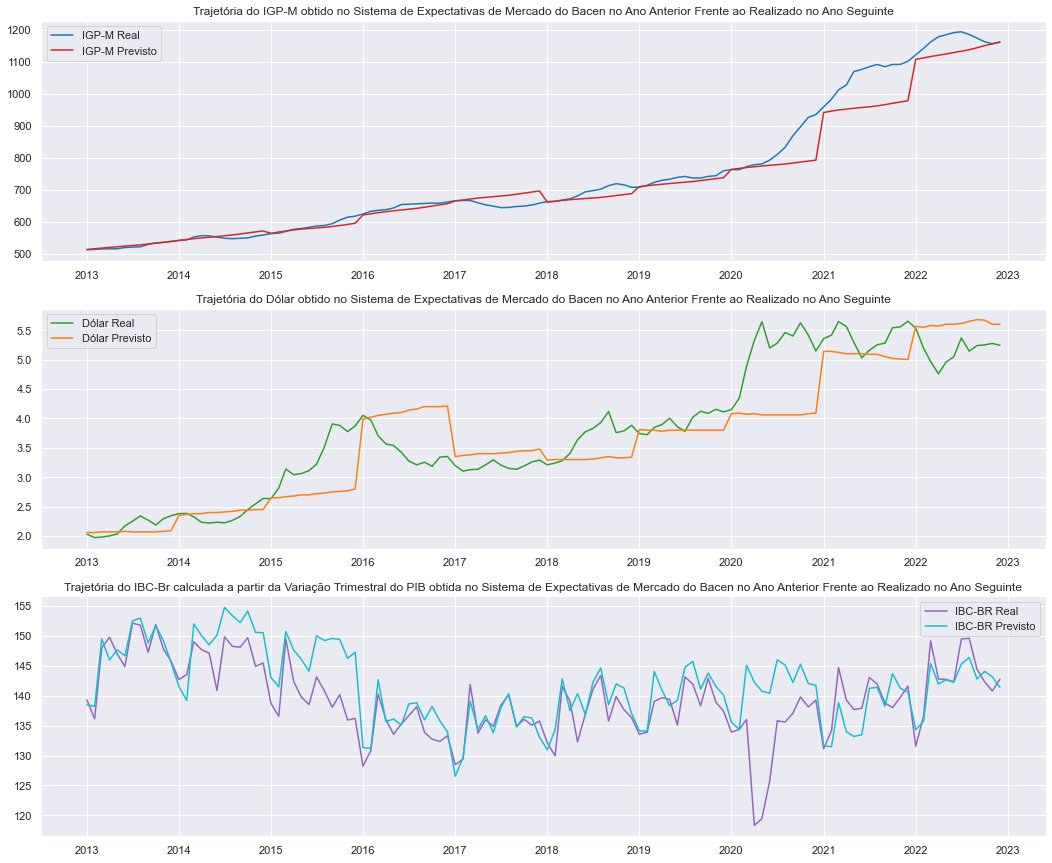

In [9]:
fig=plt.figure(figsize=(18, 15))
ax1=fig.add_subplot(311)
ax2=fig.add_subplot(312)
ax3=fig.add_subplot(313)
#plots
ax1.plot(igp_m_real, 'tab:blue', label='IGP-M Real')
ax1.plot(igp_m_prev, 'tab:red', label='IGP-M Previsto')
ax1.legend(loc='best')
ax1.set_title('Trajetória do IGP-M obtido no Sistema de Expectativas de Mercado do Bacen no '+
              'Ano Anterior Frente ao Realizado no Ano Seguinte')
ax2.plot(dolar_real, 'tab:green', label='Dólar Real')
ax2.plot(dolar_prev, 'tab:orange', label='Dólar Previsto')
ax2.set_title('Trajetória do Dólar obtido no Sistema de Expectativas de Mercado do Bacen no '+
              'Ano Anterior Frente ao Realizado no Ano Seguinte')
ax2.legend(loc='best')
ax3.plot(ibc_br_real, 'tab:purple',  label='IBC-BR Real')
ax3.plot(ibc_br_prev, 'tab:cyan',  label='IBC-BR Previsto')
ax3.set_title('Trajetória do IBC-Br calculada a partir da Variação Trimestral do PIB obtida no Sistema de '+
              'Expectativas de Mercado do Bacen no Ano Anterior Frente ao Realizado no Ano Seguinte')
ax3.legend(loc='best')
plt.show()

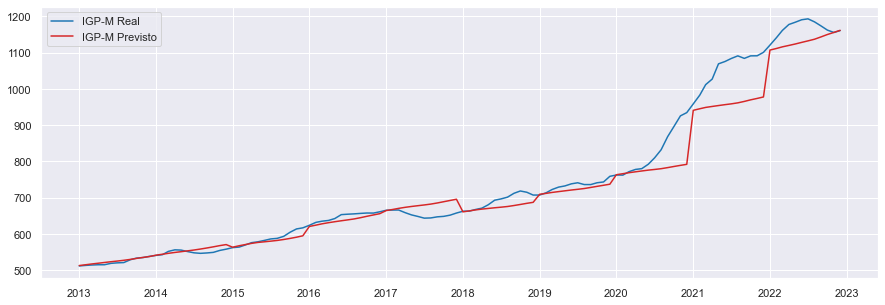

In [14]:
fig=plt.figure(figsize=(15, 5))
ax1 = plt.plot(igp_m_real, 'tab:blue', label='IGP-M Real')
ax1 = plt.plot(igp_m_prev, 'tab:red', label='IGP-M Previsto')
plt.legend(loc='best')
plt.show()

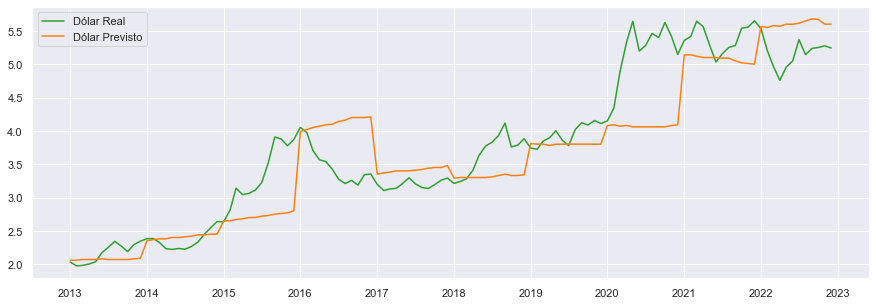

In [15]:
fig=plt.figure(figsize=(15, 5))
plt.plot(dolar_real, 'tab:green', label='Dólar Real')
plt.plot(dolar_prev, 'tab:orange', label='Dólar Previsto')
plt.legend(loc='best')
plt.show()

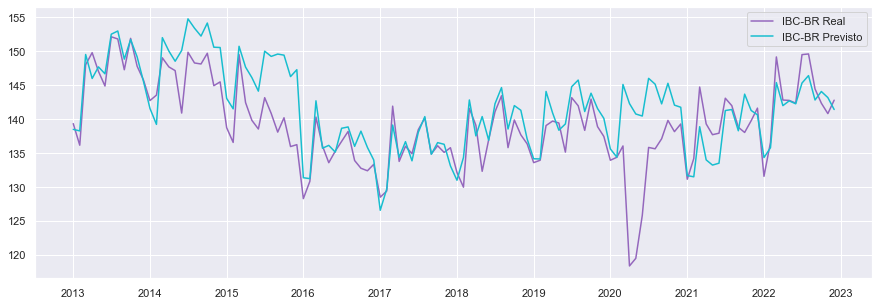

In [16]:
fig=plt.figure(figsize=(15, 5))
plt.plot(ibc_br_real, 'tab:purple',  label='IBC-BR Real')
plt.plot(ibc_br_prev, 'tab:cyan',  label='IBC-BR Previsto')
plt.legend(loc='best')
plt.show()